In [1]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [4]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [5]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
submission_df = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [6]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

In [ ]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [14]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00, 11.93it/s]


------------------------------
Train Loss EPOCH 1: 2.2655
Valid Loss EPOCH 1: 2.0879


  2%|▎         | 1/40 [00:22<14:28, 22.27s/it]

Train Accuracy EPOCH 1: 0.1574
Valid Accuracy EPOCH 1: 0.2417
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.93it/s]


------------------------------
Train Loss EPOCH 2: 1.9944
Valid Loss EPOCH 2: 1.7852


  5%|▌         | 2/40 [00:43<13:44, 21.68s/it]

Train Accuracy EPOCH 2: 0.2741
Valid Accuracy EPOCH 2: 0.3895
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


------------------------------
Train Loss EPOCH 3: 1.7157
Valid Loss EPOCH 3: 1.5822


  8%|▊         | 3/40 [01:05<13:19, 21.61s/it]

Train Accuracy EPOCH 3: 0.4082
Valid Accuracy EPOCH 3: 0.4555
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.93it/s]


------------------------------
Train Loss EPOCH 4: 1.5434
Valid Loss EPOCH 4: 1.4226


 10%|█         | 4/40 [01:26<12:53, 21.50s/it]

Train Accuracy EPOCH 4: 0.4986
Valid Accuracy EPOCH 4: 0.5536
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.04it/s]


------------------------------
Train Loss EPOCH 5: 1.3925
Valid Loss EPOCH 5: 1.2288


 12%|█▎        | 5/40 [01:47<12:32, 21.49s/it]

Train Accuracy EPOCH 5: 0.5749
Valid Accuracy EPOCH 5: 0.6576
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


------------------------------
Train Loss EPOCH 6: 1.2472
Valid Loss EPOCH 6: 1.1059


 15%|█▌        | 6/40 [02:09<12:09, 21.47s/it]

Train Accuracy EPOCH 6: 0.6511
Valid Accuracy EPOCH 6: 0.7245
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.94it/s]


------------------------------
Train Loss EPOCH 7: 1.1242
Valid Loss EPOCH 7: 0.9854


 18%|█▊        | 7/40 [02:30<11:46, 21.42s/it]

Train Accuracy EPOCH 7: 0.7007
Valid Accuracy EPOCH 7: 0.7629
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.85it/s]


------------------------------
Train Loss EPOCH 8: 1.0250
Valid Loss EPOCH 8: 0.8892


 20%|██        | 8/40 [02:52<11:26, 21.46s/it]

Train Accuracy EPOCH 8: 0.7293
Valid Accuracy EPOCH 8: 0.7802
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


------------------------------
Train Loss EPOCH 9: 0.9414
Valid Loss EPOCH 9: 0.8354


 22%|██▎       | 9/40 [03:13<11:06, 21.49s/it]

Train Accuracy EPOCH 9: 0.7556
Valid Accuracy EPOCH 9: 0.7974
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


------------------------------
Train Loss EPOCH 10: 0.8846
Valid Loss EPOCH 10: 0.7727


 25%|██▌       | 10/40 [03:35<10:47, 21.60s/it]

Train Accuracy EPOCH 10: 0.7717
Valid Accuracy EPOCH 10: 0.8200
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.46it/s]


------------------------------
Train Loss EPOCH 11: 0.8248
Valid Loss EPOCH 11: 0.7173


 28%|██▊       | 11/40 [03:57<10:26, 21.61s/it]

Train Accuracy EPOCH 11: 0.7856
Valid Accuracy EPOCH 11: 0.8283
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


------------------------------
Train Loss EPOCH 12: 0.7733
Valid Loss EPOCH 12: 0.6606


 30%|███       | 12/40 [04:18<10:02, 21.53s/it]

Train Accuracy EPOCH 12: 0.7995
Valid Accuracy EPOCH 12: 0.8438
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.13it/s]


------------------------------
Train Loss EPOCH 13: 0.7341
Valid Loss EPOCH 13: 0.6591


 32%|███▎      | 13/40 [04:39<09:37, 21.37s/it]

Train Accuracy EPOCH 13: 0.8095
Valid Accuracy EPOCH 13: 0.8298
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.55it/s]


------------------------------
Train Loss EPOCH 14: 0.6894
Valid Loss EPOCH 14: 0.5976


 35%|███▌      | 14/40 [05:00<09:13, 21.27s/it]

Train Accuracy EPOCH 14: 0.8246
Valid Accuracy EPOCH 14: 0.8590
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


------------------------------
Train Loss EPOCH 15: 0.6534
Valid Loss EPOCH 15: 0.5680


 38%|███▊      | 15/40 [05:21<08:48, 21.13s/it]

Train Accuracy EPOCH 15: 0.8352
Valid Accuracy EPOCH 15: 0.8636
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


------------------------------
Train Loss EPOCH 16: 0.6148
Valid Loss EPOCH 16: 0.5374


 40%|████      | 16/40 [05:42<08:24, 21.02s/it]

Train Accuracy EPOCH 16: 0.8470
Valid Accuracy EPOCH 16: 0.8729
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.76it/s]


------------------------------
Train Loss EPOCH 17: 0.5785
Valid Loss EPOCH 17: 0.4778


 42%|████▎     | 17/40 [06:03<08:02, 20.98s/it]

Train Accuracy EPOCH 17: 0.8536
Valid Accuracy EPOCH 17: 0.8855
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


------------------------------
Train Loss EPOCH 18: 0.5565
Valid Loss EPOCH 18: 0.4738


 45%|████▌     | 18/40 [06:23<07:40, 20.93s/it]

Train Accuracy EPOCH 18: 0.8598
Valid Accuracy EPOCH 18: 0.8836
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.63it/s]


------------------------------
Train Loss EPOCH 19: 0.5252
Valid Loss EPOCH 19: 0.4601


 48%|████▊     | 19/40 [06:44<07:18, 20.89s/it]

Train Accuracy EPOCH 19: 0.8674
Valid Accuracy EPOCH 19: 0.8919
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


------------------------------
Train Loss EPOCH 20: 0.5015
Valid Loss EPOCH 20: 0.4176


 50%|█████     | 20/40 [07:05<06:57, 20.89s/it]

Train Accuracy EPOCH 20: 0.8724
Valid Accuracy EPOCH 20: 0.8986
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.93it/s]


------------------------------
Train Loss EPOCH 21: 0.4815
Valid Loss EPOCH 21: 0.4160


 52%|█████▎    | 21/40 [07:26<06:35, 20.81s/it]

Train Accuracy EPOCH 21: 0.8751
Valid Accuracy EPOCH 21: 0.9033
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


------------------------------
Train Loss EPOCH 22: 0.4599
Valid Loss EPOCH 22: 0.3924


 55%|█████▌    | 22/40 [07:46<06:14, 20.80s/it]

Train Accuracy EPOCH 22: 0.8823
Valid Accuracy EPOCH 22: 0.9057
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.39it/s]


------------------------------
Train Loss EPOCH 23: 0.4486
Valid Loss EPOCH 23: 0.3824


 57%|█████▊    | 23/40 [08:08<05:55, 20.90s/it]

Train Accuracy EPOCH 23: 0.8835
Valid Accuracy EPOCH 23: 0.9031
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.72it/s]


------------------------------
Train Loss EPOCH 24: 0.4374
Valid Loss EPOCH 24: 0.3699


 60%|██████    | 24/40 [08:28<05:34, 20.90s/it]

Train Accuracy EPOCH 24: 0.8843
Valid Accuracy EPOCH 24: 0.9081
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.72it/s]


------------------------------
Train Loss EPOCH 25: 0.4110
Valid Loss EPOCH 25: 0.3648


 62%|██████▎   | 25/40 [08:49<05:13, 20.93s/it]

Train Accuracy EPOCH 25: 0.8925
Valid Accuracy EPOCH 25: 0.9064
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.69it/s]


------------------------------
Train Loss EPOCH 26: 0.4000
Valid Loss EPOCH 26: 0.3328


 65%|██████▌   | 26/40 [09:11<04:53, 20.97s/it]

Train Accuracy EPOCH 26: 0.8938
Valid Accuracy EPOCH 26: 0.9176
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


------------------------------
Train Loss EPOCH 27: 0.3812
Valid Loss EPOCH 27: 0.3171


 68%|██████▊   | 27/40 [09:31<04:32, 20.94s/it]

Train Accuracy EPOCH 27: 0.8966
Valid Accuracy EPOCH 27: 0.9207
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.56it/s]


------------------------------
Train Loss EPOCH 28: 0.3622
Valid Loss EPOCH 28: 0.3106


 70%|███████   | 28/40 [09:53<04:12, 21.01s/it]

Train Accuracy EPOCH 28: 0.9044
Valid Accuracy EPOCH 28: 0.9236
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


------------------------------
Train Loss EPOCH 29: 0.3605
Valid Loss EPOCH 29: 0.3158


 72%|███████▎  | 29/40 [10:14<03:51, 21.03s/it]

Train Accuracy EPOCH 29: 0.9042
Valid Accuracy EPOCH 29: 0.9193
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.90it/s]


------------------------------
Train Loss EPOCH 30: 0.3452
Valid Loss EPOCH 30: 0.2786


 75%|███████▌  | 30/40 [10:34<03:29, 20.97s/it]

Train Accuracy EPOCH 30: 0.9054
Valid Accuracy EPOCH 30: 0.9305
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.39it/s]


------------------------------
Train Loss EPOCH 31: 0.3404
Valid Loss EPOCH 31: 0.3209


 78%|███████▊  | 31/40 [10:55<03:08, 20.94s/it]

Train Accuracy EPOCH 31: 0.9063
Valid Accuracy EPOCH 31: 0.9117
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.86it/s]


------------------------------
Train Loss EPOCH 32: 0.3371
Valid Loss EPOCH 32: 0.2786


 80%|████████  | 32/40 [11:16<02:47, 20.92s/it]

Train Accuracy EPOCH 32: 0.9054
Valid Accuracy EPOCH 32: 0.9267
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.76it/s]


------------------------------
Train Loss EPOCH 33: 0.3166
Valid Loss EPOCH 33: 0.2698


 82%|████████▎ | 33/40 [11:37<02:26, 20.88s/it]

Train Accuracy EPOCH 33: 0.9144
Valid Accuracy EPOCH 33: 0.9298
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


------------------------------
Train Loss EPOCH 34: 0.3089
Valid Loss EPOCH 34: 0.2585


 85%|████████▌ | 34/40 [11:58<02:05, 20.89s/it]

Train Accuracy EPOCH 34: 0.9147
Valid Accuracy EPOCH 34: 0.9319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.73it/s]


------------------------------
Train Loss EPOCH 35: 0.3057
Valid Loss EPOCH 35: 0.2597


 88%|████████▊ | 35/40 [12:19<01:44, 20.88s/it]

Train Accuracy EPOCH 35: 0.9144
Valid Accuracy EPOCH 35: 0.9314
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


------------------------------
Train Loss EPOCH 36: 0.2889
Valid Loss EPOCH 36: 0.2421


 90%|█████████ | 36/40 [12:40<01:23, 20.91s/it]

Train Accuracy EPOCH 36: 0.9189
Valid Accuracy EPOCH 36: 0.9338
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.76it/s]


------------------------------
Train Loss EPOCH 37: 0.2811
Valid Loss EPOCH 37: 0.2307


 92%|█████████▎| 37/40 [13:01<01:02, 20.90s/it]

Train Accuracy EPOCH 37: 0.9210
Valid Accuracy EPOCH 37: 0.9381
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


------------------------------
Train Loss EPOCH 38: 0.2818
Valid Loss EPOCH 38: 0.2369


 95%|█████████▌| 38/40 [13:21<00:41, 20.89s/it]

Train Accuracy EPOCH 38: 0.9208
Valid Accuracy EPOCH 38: 0.9355
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


------------------------------
Train Loss EPOCH 39: 0.2705
Valid Loss EPOCH 39: 0.2176


 98%|█████████▊| 39/40 [13:42<00:20, 20.83s/it]

Train Accuracy EPOCH 39: 0.9224
Valid Accuracy EPOCH 39: 0.9421
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


------------------------------
Train Loss EPOCH 40: 0.2665
Valid Loss EPOCH 40: 0.2254


100%|██████████| 40/40 [14:03<00:00, 21.09s/it]

Train Accuracy EPOCH 40: 0.9261
Valid Accuracy EPOCH 40: 0.9424
------------------------------
Training Time: 843.68s


In [16]:
torch.cuda.empty_cache()

In [17]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00,  9.37it/s]


<Figure size 640x480 with 0 Axes>

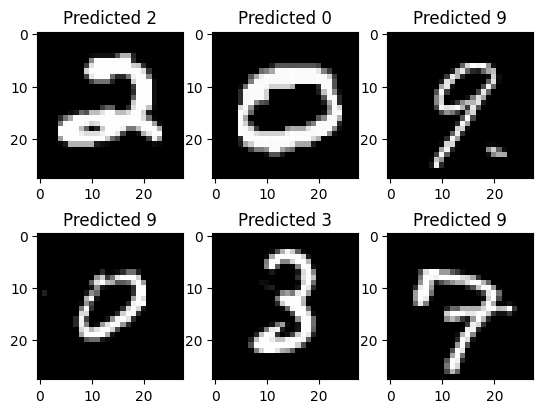

In [18]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [19]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
